# Station connections

In [63]:
%matplotlib inline
import sodapy
import matplotlib.pyplot as pp
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
import fiona
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
import json
import datetime

In [96]:
# Get bounding box for Chicago
chi_hoods = fiona.open('chi_nhoods/chi_nhoods.shp')
bbox = chi_hoods.bounds
chi_hoods.close()

map = Basemap(projection='tmerc', ellps='WGS84',
              lon_0=0.5*(bbox[0] + bbox[2]),
              lat_0=0.5*(bbox[1] + bbox[2]),
              llcrnrlon=bbox[0], llcrnrlat=bbox[1],
              urcrnrlon=bbox[2], urcrnrlat=bbox[3]+0.01,
              resolution='i', suppress_ticks=True)

map.readshapefile('chi_nhoods/chi_nhoods', name='chicago',
                  drawbounds=False, color='none', zorder=2)
pass

In [97]:
# Read station data
stations = pd.read_csv('stations.csv')

# Convert station lon,lat to mapped x,y
stations['map_point'] = [Point(map(x, y)) for x, y in zip(stations['longitude'], stations['latitude'])]

print stations.head()

   id   latitude  longitude              station_name  total_docks  \
0   2  41.872638 -87.623979  Michigan Ave & Balbo Ave           35   
1   3  41.867226 -87.615355            Shedd Aquarium           31   
2   4  41.856268 -87.613348            Burnham Harbor           23   
3   5  41.874053 -87.627716    State St & Harrison St           23   
4   6  41.885042 -87.612795            Dusable Harbor           31   

                                     map_point  
0  POINT (26305.44940608979 25318.93486388586)  
1  POINT (27022.16283313817 24718.75290240254)  
2   POINT (27190.5057286895 23501.87439238094)  
3   POINT (25995.02825964771 25475.7160122795)  
4  POINT (27232.02070866526 26697.88840549532)  


In [98]:
# Read neighborhoods shapefile
hoods = pd.DataFrame({'poly': [Polygon(xy) for xy in map.chicago],
                      'name': [n['pri_neigh'] for n in map.chicago_info]})

# Create a patch for each neighborhood
hoods['patch'] = hoods['poly']\
    .map(lambda x: PolygonPatch(x, fc='#555555',
                                ec='#787878', lw=.25, alpha=.9,
                                zorder=4))

rp_poly = hoods[hoods.name == 'Rogers Park']['poly'].values[0]

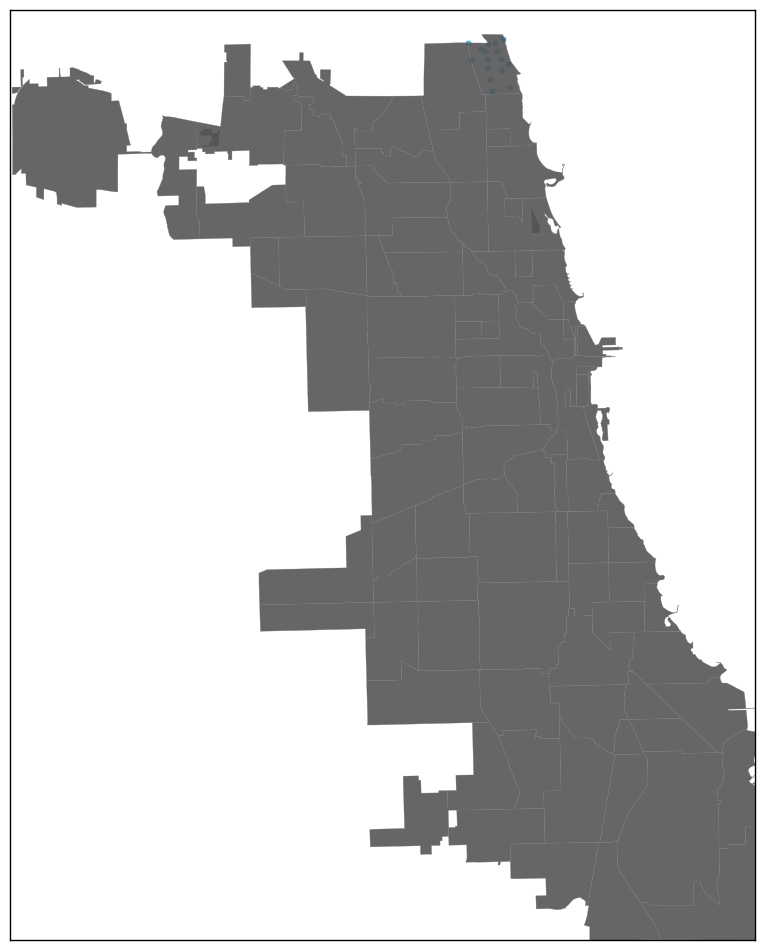

In [100]:
fig = pp.figure(figsize=(12, 12))
ax = pp.axes()

map.scatter([pt.x for pt in stations['map_point'] if rp_poly.contains(pt)],
            [pt.y for pt in stations['map_point'] if rp_poly.contains(pt)],
            s=10, facecolor='#3db7e4', edgecolor='#3db7e4')

ax.add_collection(PatchCollection(hoods['patch'].values, match_original=True))

pp.show()